# Overview of the Experimental Models
## With comparisons against finalized Baselines

Prerequisites:

- numpy
- pandas
- scipy
- matplotlib
- sklearn>=1.0.2
- sktime==0.10.0
- xgboost>=1.5.0
- pygam>=0.8.0

The experimental models shown are chosen using the following criteria:

1. Whether they have a direct equivalent baseline model, e.g. XGBoost classifier model.  
2. Whether they are representative of their modelling technique type, i.e. one model for tree-based and one for time series-based, etc.  
3. Whether the model in question has shown notable behaviour, i.e. performance comparable to the best ones selected using the aforementioned criteria.

The models will be compared against the baseline models shown in `baseline__overview_full_ds.ipynb`, which were built using the full baseline TSNV dataset in general, and then against models that use a downsampled baseline TSNV to match the number of samples in the experimental/hybrid dataset.

Important precautions:

1. The effects of calibration and hyperparameter optimization may not be evident, because they may depend on the train/test split.  
2. Some of the code seem to be manually rewritten instead of abstracted into helper functions, because the models that use them do not cooperate and need some extra handling.

In [2]:
# import statements
import numpy as np
import pandas as pd
import joblib
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# data
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def TSToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

tsnv_dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
tsnv_dataset = separateDataset(tsnv_dataset, 0.9)
train_X, train_Y = TSToXY(tsnv_dataset["train"])
dev_X, dev_Y = TSToXY(tsnv_dataset["dev"])
test_X, test_Y = TSToXY(tsnv_dataset["test"])

Training set size: 5633; Dev set size: 626; Testing set size: 696


In [4]:
# make calibration plots for class (label) 0 and 3
from sklearn.metrics import brier_score_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.neural_network import MLPClassifier

def calibration_plot(clf, dataset_X, dataset_Y, probs_given=False, probs=None):
    '''
    Takes in a classifier, an input set X and a target set Y; 
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    if probs_given:
        all_preds = probs
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    
    # brier score loss
    print("Brier score losses: (the smaller the better)")
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X)) if not probs_given else probs
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X)) if not probs_given else probs
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [4]:
# make predictions according to the given thresholds
from scipy.special import expit

def predictions_with_thresholds(clf, thresholds, datasetX, probs_given=False, probs=None):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    Returns deterministic predictions made using the model over X and the thresholds.
    '''    
    if probs_given:
        preds_probs = probs
    else:
        preds_probs = np.array(clf.predict_proba(datasetX))
    
    if isinstance(clf, MultiOutputClassifier):
        preds_probs = np.array(preds_probs)[:,:,1].T
    n_classes = 4
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

def regression_label(regr, datasetX, thresholds, probs_given=False, probs=None):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X;
    optionally precomputed probability predictions (probs=, use probs_given=True to enable);
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    if probs_given:
        preds_probs = probs
    else:
        preds_probs = np.clip(regr.predict(datasetX),0,1)
    
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [5]:
# metrics
from sklearn.metrics import classification_report

## Model Type 1: Tree-Based Classifiers

This group has a couple variants, depending on whether probability calibration was performed. The models to show include

- multi-output XGBoost classifier  
- multi-output XGBoost classifier (calibrated)  
- multi-output XGBoost regressor  
- multi-output extra trees classifier (default settings)  
- multi-output extra trees classifier (grid search optimized settings)  
- multi-output extra trees classifier (grid search optimized settings, calibrated)  
- multi-output extra trees regressor (grid search optimized settings)  

The best results for an uncalibrated baseline multi-output XGBoost classifier are:

- Full dataset  
  f1-score \[0.87970 0.86149 0.81702 0.69620\] average 0.81360; Brier score losses: \[0.017328 0.015509 0.008232 0.009915\]  

- Downsampled dataset: depends on what we compare, see below for details. Best Brier scores: \[0.010723 0.012499 0.008748 0.007862\]

The results show that the experimental dataset is indeed better, at least for trees; and Brier scores did improve a *little* bit (extra trees: \[0.008425 0.010044 0.005576 0.008533\]).

##### 1A. multi-output XGBoost classifier 

(downsampled) baseline f1-score \[0.91192 0.90625 0.79070 0.89655\] average 0.87635  
this one f1-score \[0.95425 0.94643 0.94444 0.86667\] average **0.92795**

In [5]:
# imports
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

xgb_clf = joblib.load("./models/experimental_model_gscv_xgb_clf_2022-04-12 19-13.skl")
xgb_thresholds = [0.44700, 0.24275, 0.25802, 0.15740]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008347
Class 1, no calibration: 0.008071
Class 2, no calibration: 0.001275
Class 3, no calibration: 0.006889


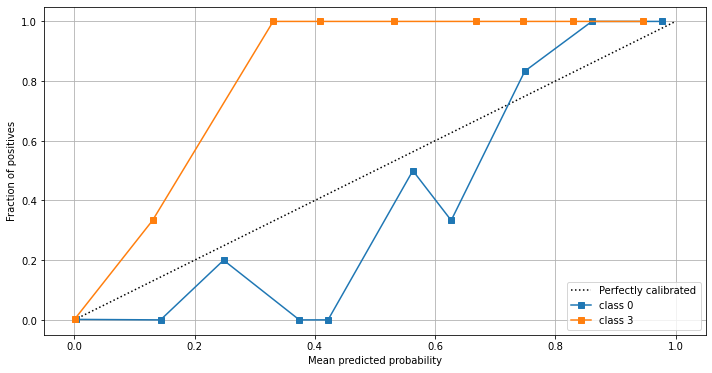

In [7]:
calibration_plot(xgb_clf, test_X, test_Y)

In [10]:
preds = predictions_with_thresholds(xgb_clf, xgb_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.93590   0.97333   0.95425        75
           1    0.96364   0.92982   0.94643        57
           2    0.89474   1.00000   0.94444        17
           3    0.92857   0.81250   0.86667        16

   micro avg    0.93976   0.94545   0.94260       165
   macro avg    0.93071   0.92891   0.92795       165
weighted avg    0.94053   0.94545   0.94204       165
 samples avg    0.10824   0.10800   0.10706       165



##### 1B. multi-output XGBoost classifier (calibrated)

In [11]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

xgb_calibrated_clf = joblib.load("./models/experimental_model_calibrated_gscv_xgb_clf_2022-04-12 19-15.skl")
xgb_calibrated_thresholds = [0.37934, 0.07244, 0.31231, 0.06713]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008291
Class 1, no calibration: 0.007923
Class 2, no calibration: 0.000811
Class 3, no calibration: 0.004592


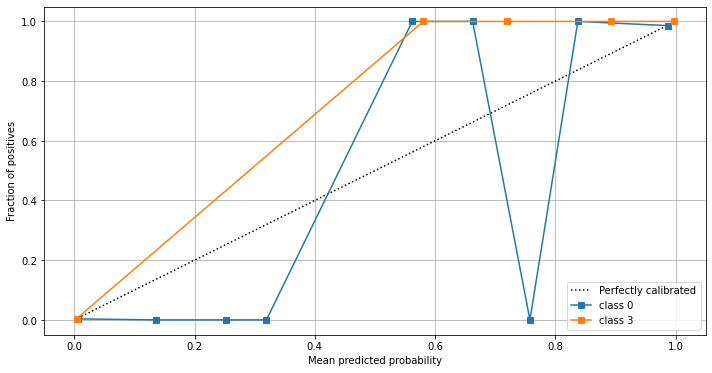

In [12]:
calibration_plot(xgb_calibrated_clf, test_X, test_Y)

In [13]:
preds = predictions_with_thresholds(xgb_calibrated_clf, xgb_calibrated_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.93590   0.97333   0.95425        75
           1    0.96364   0.92982   0.94643        57
           2    0.89474   1.00000   0.94444        17
           3    0.92857   0.81250   0.86667        16

   micro avg    0.93976   0.94545   0.94260       165
   macro avg    0.93071   0.92891   0.92795       165
weighted avg    0.94053   0.94545   0.94204       165
 samples avg    0.10824   0.10800   0.10706       165



##### 1C. multi-output XGBoost regressor
baseline: 0.90432 (jeez), this one 0.87246

In [26]:
xgb_regr = joblib.load("./models/experimental_model_gscv_xgb_regr_2022-04-16 20-15.skl")
xgb_regr_thresholds = [0.44714, 0.39379, 0.27891, 0.22038]

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.016766
Class 1, no calibration: 0.014163
Class 2, no calibration: 0.006650
Class 3, no calibration: 0.008458


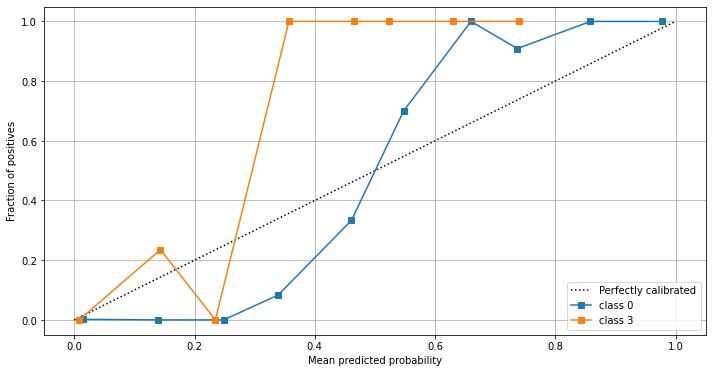

In [28]:
calibration_plot(xgb_regr, test_X, test_Y, probs_given=True, probs=np.clip(xgb_regr.predict(test_X), 0, 1))

In [29]:
preds = regression_label(xgb_regr, test_X, xgb_regr_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.90000   0.96000   0.92903        75
           1    0.91379   0.92982   0.92174        57
           2    0.80000   0.94118   0.86486        17
           3    0.80000   0.75000   0.77419        16

   micro avg    0.88439   0.92727   0.90533       165
   macro avg    0.85345   0.89525   0.87246       165
weighted avg    0.88476   0.92727   0.90489       165
 samples avg    0.10560   0.10692   0.10441       165



##### 1D. multi-output extra trees classifier (default settings)

baseline: 0.86523, exp.: **0.88828**

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = joblib.load("./models/experimental_model_extra_trees_clf_2022-04-12 19-17.skl")
extra_trees_thresholds = [0.44000, 0.42000, 0.35000, 0.19000]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.013365
Class 1, no calibration: 0.013886
Class 2, no calibration: 0.007864
Class 3, no calibration: 0.008503


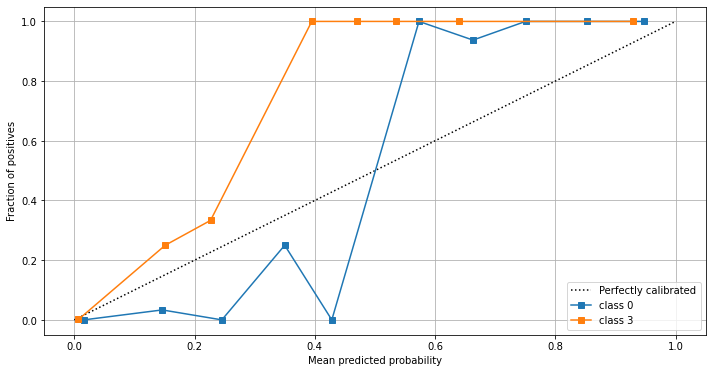

In [15]:
calibration_plot(extra_trees_clf, test_X, test_Y)

In [16]:
preds = predictions_with_thresholds(extra_trees_clf, extra_trees_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.97333   0.97333   0.97333        75
           1    0.94545   0.91228   0.92857        57
           2    0.86667   0.76471   0.81250        17
           3    0.86667   0.81250   0.83871        16

   micro avg    0.94375   0.91515   0.92923       165
   macro avg    0.91303   0.86570   0.88828       165
weighted avg    0.94237   0.91515   0.92825       165
 samples avg    0.10848   0.10644   0.10556       165



##### 1E. multi-output extra trees classifier (grid search optimized settings) 

baseline f1-score \[0.93814 0.95312 0.88889 0.75862\] average 0.88469  
this one f1-score \[0.94872 0.94545 0.94118 0.75862\] average **0.89849**

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_gscv_clf = joblib.load("./models/experimental_model_gscv_extra_trees_clf_2022-04-12 19-18.skl")
extra_trees_gscv_thresholds = [0.32000, 0.47000, 0.36000, 0.28000]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008425
Class 1, no calibration: 0.010044
Class 2, no calibration: 0.005576
Class 3, no calibration: 0.008533


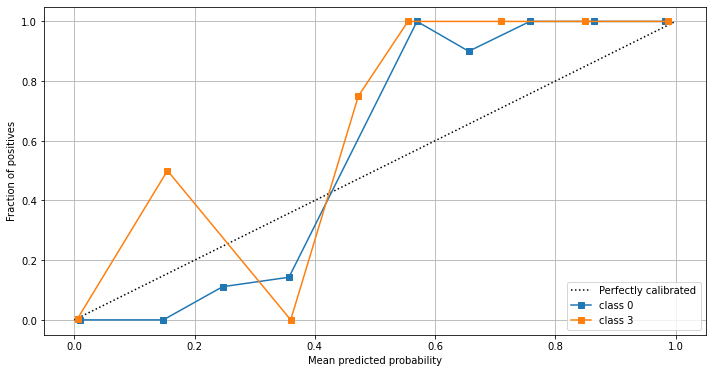

In [18]:
calibration_plot(extra_trees_gscv_clf, test_X, test_Y)

In [7]:
preds = predictions_with_thresholds(extra_trees_gscv_clf, extra_trees_gscv_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.91358   0.98667   0.94872        75
           1    0.98113   0.91228   0.94545        57
           2    0.94118   0.94118   0.94118        17
           3    0.84615   0.68750   0.75862        16

   micro avg    0.93293   0.92727   0.93009       165
   macro avg    0.92051   0.88191   0.89849       165
weighted avg    0.93322   0.92727   0.92838       165
 samples avg    0.11051   0.10800   0.10783       165



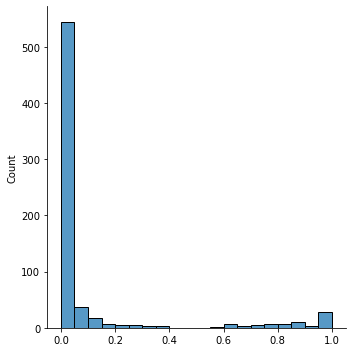

In [21]:
import seaborn as sns

sns.displot(np.array(extra_trees_gscv_clf.predict_proba(test_X))[0,:,1], bins=20)

##### 1F. multi-output extra trees classifier (optimized settings, calibrated)

In [20]:
extra_trees_calibrated_clf = joblib.load("./models/experimental_model_calibrated_gscv_extra_trees_clf_2022-04-12 19-23.skl")
extra_trees_calibrated_thresholds = [0.13371, 0.68536, 0.40297, 0.20921]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.003810
Class 1, no calibration: 0.006971
Class 2, no calibration: 0.002877
Class 3, no calibration: 0.008682


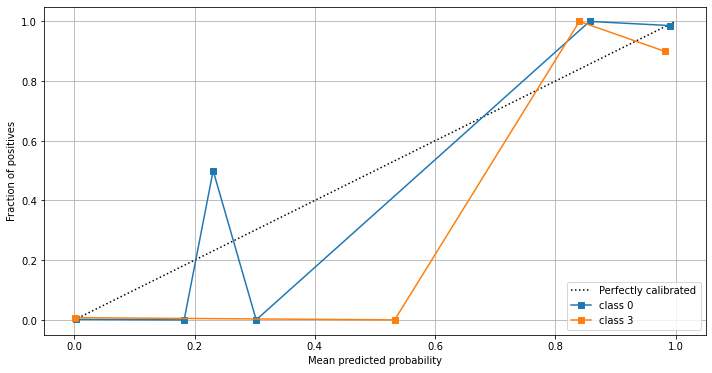

In [21]:
calibration_plot(extra_trees_calibrated_clf, test_X, test_Y)

In [22]:
preds = predictions_with_thresholds(extra_trees_calibrated_clf, extra_trees_calibrated_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.91358   0.98667   0.94872        75
           1    0.98113   0.91228   0.94545        57
           2    0.94118   0.94118   0.94118        17
           3    0.84615   0.68750   0.75862        16

   micro avg    0.93293   0.92727   0.93009       165
   macro avg    0.92051   0.88191   0.89849       165
weighted avg    0.93322   0.92727   0.92838       165
 samples avg    0.11051   0.10800   0.10783       165



##### 1G. multi-output extra trees regressor (optimized settings)
before experimental dataset: 0.89117, after: 0.89823

In [6]:
extra_trees_regr = joblib.load("./models/experimental_model_gscv_extra_trees_regr_2022-04-16 17-15.skl")
extra_trees_regr_thresholds = [0.34483, 0.47204, 0.30000, 0.28276]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.009257
Class 1, no calibration: 0.010654
Class 2, no calibration: 0.006638
Class 3, no calibration: 0.008367


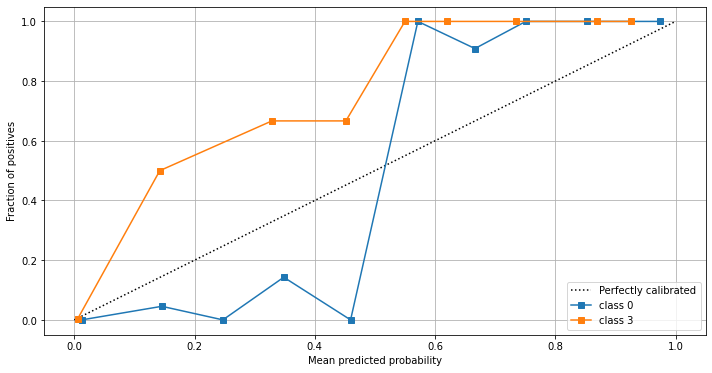

In [13]:
calibration_plot(extra_trees_regr, test_X, test_Y, probs_given=True, probs=extra_trees_regr.predict(test_X))

In [12]:
preds = regression_label(extra_trees_regr, test_X, extra_trees_regr_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.92405   0.97333   0.94805        75
           1    0.98077   0.89474   0.93578        57
           2    0.93750   0.88235   0.90909        17
           3    0.85714   0.75000   0.80000        16

   micro avg    0.93789   0.91515   0.92638       165
   macro avg    0.92487   0.87511   0.89823       165
weighted avg    0.93854   0.91515   0.92544       165
 samples avg    0.10836   0.10620   0.10535       165



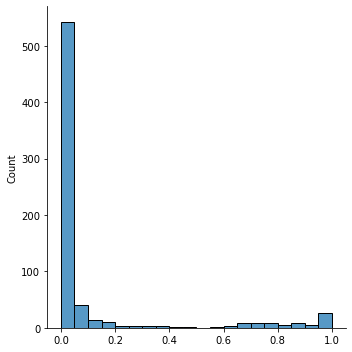

In [18]:
import seaborn as sns

sns.displot(extra_trees_regr.predict(test_X)[:,0], bins=20)

## Model Type 2: Multilayer Perceptron

There is only one MLP model. Prior performances are as follows:

- Full dataset  
  f1-score \[0.85350 0.82956 0.73684 0.64828\] average 0.76705; Brier score losses: \[0.022955 0.018298 0.010532 0.009146\]  
  
- Downsampled dataset
  f1-score \[0.76744 0.76800 0.52381 0.72000\] average 0.69481; Brier score losses: \[0.040058 0.033040 0.018066 0.011381\]

##### 2. MLP classifier

baseline 0.69841, this one f1-score \[0.81081 0.83495 0.84848 0.50000\] average 0.74856; Brier score \[0.028545 0.020314 0.008420 0.014340\]  
the performances in targets 0 and 4 could not be recreated. Calibration was ineffective.

In [10]:
from sklearn.neural_network import MLPClassifier

mlp_clf = joblib.load("./models/experimental_model_mlpclf_2022-04-12 21-18.skl")
mlp_clf_thresholds = [0.20008, 0.40084, 0.45346, 0.32988]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.028545
Class 1, no calibration: 0.020314
Class 2, no calibration: 0.008420
Class 3, no calibration: 0.014340


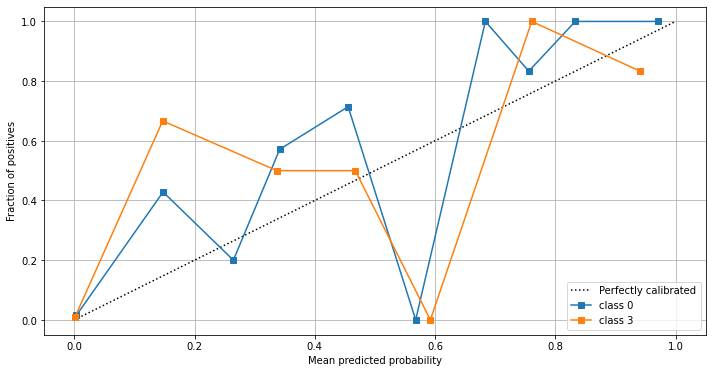

In [7]:
calibration_plot(mlp_clf, test_X, test_Y)

In [11]:
preds = predictions_with_thresholds(mlp_clf, mlp_clf_thresholds, test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.82192   0.80000   0.81081        75
           1    0.93478   0.75439   0.83495        57
           2    0.87500   0.82353   0.84848        17
           3    0.58333   0.43750   0.50000        16

   micro avg    0.84354   0.75152   0.79487       165
   macro avg    0.80376   0.70385   0.74856       165
weighted avg    0.84324   0.75152   0.79289       165
 samples avg    0.08800   0.08417   0.08365       165



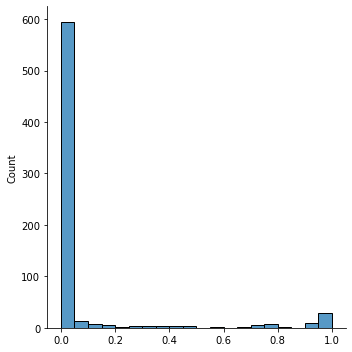

In [16]:
import seaborn as sns

sns.displot(mlp_clf.predict_proba(test_X)[:,0], bins=20)

## Model Type 3: Time Series Modelling

There are 3 models available:
- sktime time series forest classifier  
- sktime time series forest classifier (calibrated) 
- sktime time series forest regressor  

Prior performances:
- Full dataset
  f1-score \[0.75058 0.75584 0.72414 0.67974\] average 0.72757; Brier score losses: \[0.035992 0.028371 0.014414 0.010481\]  

- Downsampled dataset: new best score 0.73426; Brier score losses \[0.032439 0.027855 0.012812 0.010691\]

Once more we see improvement in all aspects. Pre-calibration Brier \[0.028260 0.024485 0.010301 0.012298\]

In [21]:
# special data preprocessing for sktime
from sktime.transformations.panel.compose import ColumnConcatenator
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    to_drop = ["DVMAX{0:02d}".format(i) for i in range(0, PAST_TRACK_LIMIT, 6)]
    print("dropping", to_drop)
    dataset_X = dataset_X.drop(to_drop, axis=1)
    
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(29):
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 1000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

concat_test_X = convert_X(test_X)
print("Before transform:", concat_test_X.shape)
concat_test_X = ColumnConcatenator().fit_transform(concat_test_X)
print("After transform:", concat_test_X.shape)
print("Each element is:", concat_test_X.iloc[0].iloc[0].shape)

dropping ['DVMAX00', 'DVMAX06', 'DVMAX12', 'DVMAX18']
Completed
Before transform: (696, 29, 5)
After transform: (696, 1)
Each element is: (145,)


##### 3A. sktime time series forest classifier 
baseline f1-score \[0.82558 0.79688 0.70588 0.60870\] average 0.73426  
this one f1-score \[0.89032 0.83186 0.80000 0.72727\] average **0.81236**

In [24]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

tsfs_clf = joblib.load("./models/experimental_model_gscv_tsfs_clf_2022-04-12 19-31.skl")
tsfs_clf_thresholds = [0.40333, 0.39000, 0.28000, 0.16667]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.028260
Class 1, no calibration: 0.024485
Class 2, no calibration: 0.010301
Class 3, no calibration: 0.012298


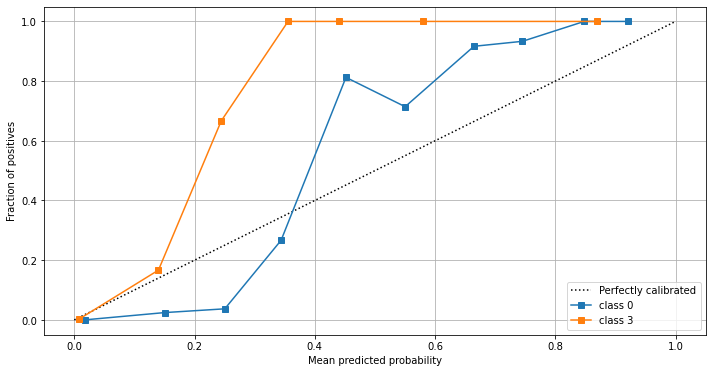

In [25]:
calibration_plot(tsfs_clf, concat_test_X, test_Y)

In [26]:
preds = predictions_with_thresholds(tsfs_clf, tsfs_clf_thresholds, concat_test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.86250   0.92000   0.89032        75
           1    0.83929   0.82456   0.83186        57
           2    0.69565   0.94118   0.80000        17
           3    0.70588   0.75000   0.72727        16

   micro avg    0.81818   0.87273   0.84457       165
   macro avg    0.77583   0.85893   0.81236       165
weighted avg    0.82210   0.87273   0.84501       165
 samples avg    0.09806   0.10057   0.09686       165



##### 3B. sktime time series forest classifier (calibrated)
average score dropped to 0.80568 but it's still pretty good.

In [38]:
tsfs_calibrated_clf = joblib.load("./models/experimental_model_calibrated_gscv_tsfs_clf_2022-04-12 20-11.skl")
tsfs_calibrated_clf_thresholds = [0.43445, 0.51001, 0.28229, 0.08528]

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.020349
Class 1, no calibration: 0.018920
Class 2, no calibration: 0.007636
Class 3, no calibration: 0.008170


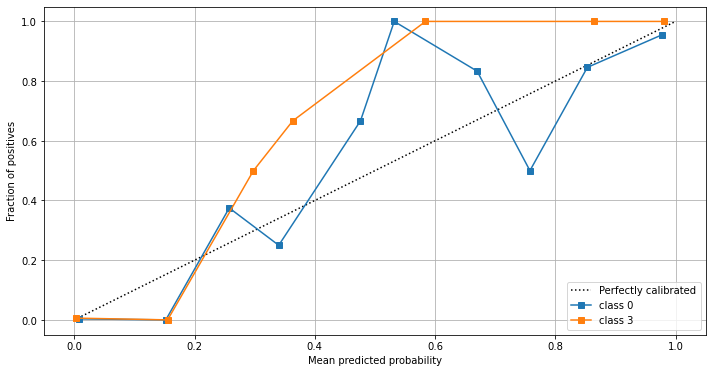

In [39]:
calibration_plot(tsfs_calibrated_clf, concat_test_X, test_Y)

In [40]:
preds = predictions_with_thresholds(tsfs_calibrated_clf, tsfs_calibrated_clf_thresholds, concat_test_X)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.86076   0.90667   0.88312        75
           1    0.83929   0.82456   0.83186        57
           2    0.66667   0.94118   0.78049        17
           3    0.70588   0.75000   0.72727        16

   micro avg    0.81250   0.86667   0.83871       165
   macro avg    0.76815   0.85560   0.80568       165
weighted avg    0.81833   0.86667   0.83972       165
 samples avg    0.09662   0.09914   0.09542       165



##### 3C. sktime time series forest regressor 
before: 0.73471, after: 0.72107

In [19]:
tsfs_regr = joblib.load("./models/experimental_model_gscv_tsfs_regr_2022-04-16 17-45.skl")
tsfs_regr_thresholds = [0.48222, 0.33778, 0.21778, 0.10667]

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.030188
Class 1, no calibration: 0.027210
Class 2, no calibration: 0.012045
Class 3, no calibration: 0.014258


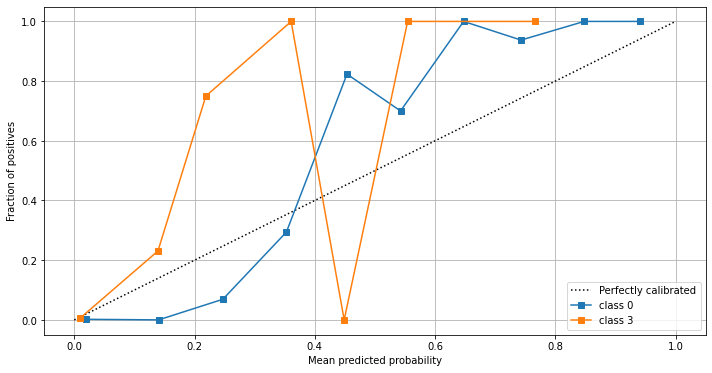

In [22]:
calibration_plot(tsfs_regr, concat_test_X, test_Y, probs_given=True, probs=tsfs_regr.predict(concat_test_X))

In [25]:
preds = regression_label(tsfs_regr, concat_test_X, tsfs_regr_thresholds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.84848   0.74667   0.79433        75
           1    0.80702   0.80702   0.80702        57
           2    0.58333   0.82353   0.68293        17
           3    0.50000   0.75000   0.60000        16

   micro avg    0.74854   0.77576   0.76190       165
   macro avg    0.68471   0.78180   0.72107       165
weighted avg    0.77305   0.77576   0.76839       165
 samples avg    0.07950   0.08609   0.07976       165



## Model Type 4: Linear Models

These are GAM models where each predictand has a dedicated GAM fitted to it. These are also the only regressional models in the list. The models selected for display below include:
- Mixed Poisson/Linear GAMs  

Prior performances:
- full baseline dataset: best score 0.60176.  

- downsampled dataset: best score 0.75851.

We are once more superior. However, the model cannot be calibrated, which is a bummer.

##### 4. Mixed Poisson/Linear GAMs
baseline f1-score \[0.82955 0.79710 0.66667 0.74074\] average 0.75851  
this one f1-score \[0.79487 0.86957 0.86486 0.71429\] average **0.81090**

The calibration of the model when the outputs are expit-adjusted (to fall into 0-1) was bad, for both the downsampled baseline and this dataset. Brier losses were \[0.247225 0.242156 0.252257 0.250173\] which are disgusting.

With clip-adjustment (`y_hat = max(0, min(1, y_hat))`), f1-score \[0.78107 0.86207 0.82353 0.66667\] average 0.78333 which isn't too bad, but calibration loss is now \[0.038010 0.021370 0.011982 0.012626\] which is very nice.

In [13]:
import pickle as pk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif #, SelectFromModel
from functools import partial
from pygam import LinearGAM, PoissonGAM

# file = open("./models/experimental_model_gam_tsnv_2022-04-07 17-49.pkl", "rb") 
file = open("./models/experimental_model_gam_tsnv_2022-04-14 18-20.pkl", "rb") 
gam = pk.load(file)
file.close()
# gam_thresholds = [0.60220, 0.56466, 0.57915, 0.57388]
gam_thresholds = [0.35238, 0.24287, 0.35914, 0.30912]

In [14]:
# generate predictions
raw_preds = []
for i in range(4):
    in_test_X = gam["poly"][i].transform(test_X.iloc[:,:(gam["input_feature_count"][i])])
    tr_test_X = gam["fs"][i].transform(in_test_X)
    # preds = expit(gam["gam"][i].predict(tr_test_X))
    preds = np.clip(gam["gam"][i].predict(tr_test_X), 0, 1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

(696, 4)


Brier score losses: (the smaller the better)
Class 0, no calibration: 0.038010
Class 1, no calibration: 0.021370
Class 2, no calibration: 0.011982
Class 3, no calibration: 0.012626


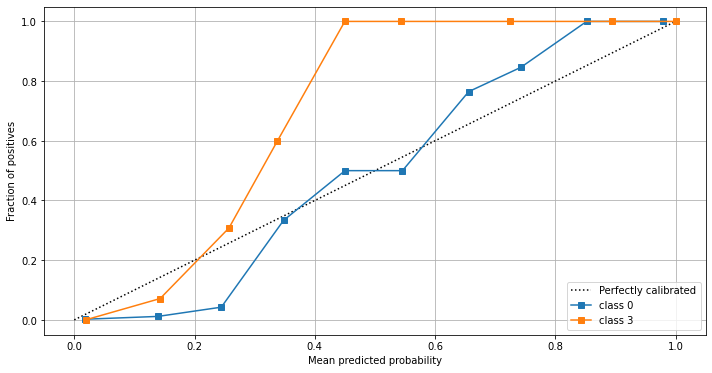

In [12]:
calibration_plot(gam, test_X, test_Y, probs_given=True, probs=raw_preds)

In [13]:
preds = regression_label(gam, test_X, gam_thresholds, probs_given=True, probs=raw_preds)
print(classification_report(test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.70213   0.88000   0.78107        75
           1    0.84746   0.87719   0.86207        57
           2    0.82353   0.82353   0.82353        17
           3    0.81818   0.56250   0.66667        16

   micro avg    0.76796   0.84242   0.80347       165
   macro avg    0.79782   0.78581   0.78333       165
weighted avg    0.77609   0.84242   0.80233       165
 samples avg    0.10045   0.09842   0.09655       165



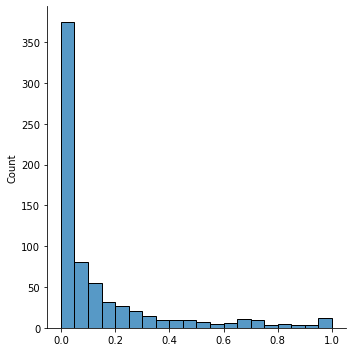

In [15]:
import seaborn as sns

sns.displot(raw_preds[:,0], bins=20)

## Feature Importances

### No polynomials, according to Trees

In [8]:
importance = np.stack([list(train_X.columns), xgb_clf.estimators_[0].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['MI_STATUS00' 'DIST00' 'STEMP00' 'AZM00' 'MM06' 'U50018' 'MM00' 'AZM12'
 'MM12' 'AZM06' 'U_HK06' 'U_HK00' 'LO_HUMID12' 'LI_STATUS06' 'U_HK18'
 'DIST06' 'MM18' 'STEMP06' 'AZM24' 'WESTERLY06' 'POTT00' 'MM24' 'DD06'
 'WESTERLY24' 'AZM18' 'DD24' 'U20012' 'DIR00' 'UTEMP00' 'U20006' 'U_HK12'
 'DIST24' 'DIST18' 'DIST12' 'DIR06' 'POTT06' 'DD00' 'LI_STATUS00'
 'MI_STATUS12' 'HI_HUMID06' 'LI_STATUS12' 'U50006' 'EASM12' 'MI_STATUS06'
 'POTT12' 'U50000' 'VORT12' 'VMAX00' 'SPEED00' 'UTEMP06']
[['MI_STATUS00' '0.11844143']
 ['DIST00' '0.04162135']
 ['STEMP00' '0.030520052']
 ['AZM00' '0.025856093']
 ['MM06' '0.024997955']
 ['U50018' '0.023949042']
 ['MM00' '0.02390792']
 ['AZM12' '0.023615694']
 ['MM12' '0.021794882']
 ['AZM06' '0.020206848']
 ['U_HK06' '0.017682415']
 ['U_HK00' '0.017590761']
 ['LO_HUMID12' '0.01754839']
 ['LI_STATUS06' '0.016054336']
 ['U_HK18' '0.014293869']
 ['DIST06' '0.014268473']
 ['MM18' '0.012822429']
 ['STEMP06' '0.01264444']
 ['AZM24' '0.012567389']
 ['WESTERLY06' '0.012

In [9]:
importance = np.stack([list(train_X.columns), xgb_clf.estimators_[1].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['DIST00' 'LI_STATUS06' 'LI_STATUS00' 'MM12' 'SH_EXT00' 'U_HK18'
 'MI_STATUS00' 'U_HK00' 'STEMP00' 'MM06' 'AZM00' 'DIST06' 'MM00' 'POTT18'
 'U50018' 'U_HK06' 'AZM12' 'SI_STATUS00' 'AZM06' 'U_HK12' 'MM18' 'AZM24'
 'SH_INT18' 'AZM18' 'DIST24' 'WESTERLY24' 'WESTERLY06' 'DIR00' 'DIR06'
 'DIST12' 'V_HK06' 'POTT06' 'VMAX18' 'MI_STATUS12' 'DIST18' 'MI_STATUS06'
 'SPEED00' 'V_HK00' 'MM24' 'VMAX06' 'VMAX00' 'U50006' 'DVMAX06' 'U20012'
 'V50018' 'POTT00' 'DD06' 'EASM06' 'WESTERLY12' 'LO_HUMID06']
[['DIST00' '0.05144232']
 ['LI_STATUS06' '0.04860658']
 ['LI_STATUS00' '0.034328207']
 ['MM12' '0.02733628']
 ['SH_EXT00' '0.026363775']
 ['U_HK18' '0.025796715']
 ['MI_STATUS00' '0.024316527']
 ['U_HK00' '0.023556361']
 ['STEMP00' '0.02337467']
 ['MM06' '0.022365438']
 ['AZM00' '0.020798676']
 ['DIST06' '0.020262953']
 ['MM00' '0.020093493']
 ['POTT18' '0.019902451']
 ['U50018' '0.019296823']
 ['U_HK06' '0.019217737']
 ['AZM12' '0.018466348']
 ['SI_STATUS00' '0.017605035']
 ['AZM06' '0.016670346']
 ['U

In [10]:
importance = np.stack([list(train_X.columns), xgb_clf.estimators_[2].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['SI_STATUS00' 'MI_STATUS00' 'DIST00' 'U50006' 'DS_STATUS00' 'EASM12'
 'DIST06' 'MM00' 'U20006' 'DIR00' 'AZM18' 'AZM12' 'DIR06' 'MM06' 'AZM24'
 'U_HK00' 'WESTERLY18' 'STEMP00' 'UTEMP18' 'V_HK06' 'U_HK18' 'EASM06'
 'UTEMP24' 'DIST12' 'STEMP06' 'EASM00' 'AZM00' 'V_HK24' 'WESTERLY06'
 'DIR18' 'DD06' 'V50012' 'POTT06' 'AZM06' 'V50000' 'EASM24' 'STEMP12'
 'VMAX24' 'DD12' 'LI_STATUS00' 'DIST18' 'DIR24' 'DD00' 'DD18' 'WESTERLY24'
 'U_HK06' 'U20012' 'V50006' 'U20000' 'POTT18']
[['SI_STATUS00' '0.08433111']
 ['MI_STATUS00' '0.055197764']
 ['DIST00' '0.031929743']
 ['U50006' '0.031635705']
 ['DS_STATUS00' '0.029281171']
 ['EASM12' '0.027485779']
 ['DIST06' '0.020751199']
 ['MM00' '0.018357737']
 ['U20006' '0.01753887']
 ['DIR00' '0.016579822']
 ['AZM18' '0.016438032']
 ['AZM12' '0.015936073']
 ['DIR06' '0.015461733']
 ['MM06' '0.01523018']
 ['AZM24' '0.015141728']
 ['U_HK00' '0.014247513']
 ['WESTERLY18' '0.013412123']
 ['STEMP00' '0.013300354']
 ['UTEMP18' '0.013258498']
 ['V_HK06' '0.01304514'

In [11]:
importance = np.stack([list(train_X.columns), xgb_clf.estimators_[3].feature_importances_], axis=1)
importance = importance[np.argsort(importance[:,1])]
print(np.flip(importance, axis=0)[:50,0])
print(np.flip(importance, axis=0)[:50,:])

['DS_STATUS00' 'POTT24' 'V50018' 'EASM24' 'MM00' 'AZM12' 'MI_STATUS00'
 'DIR06' 'DIR18' 'DIST12' 'DIST00' 'EASM18' 'EASM12' 'DIST06' 'DIR12'
 'EASM06' 'POTT18' 'AZM06' 'DIR00' 'U50006' 'MM06' 'V50012' 'UTEMP18'
 'AZM00' 'U50000' 'DIST24' 'LO_HUMID00' 'U20006' 'HI_HUMID00' 'WESTERLY24'
 'WESTERLY06' 'UTEMP00' 'MI_STATUS24' 'MM24' 'UTEMP24' 'WESTERLY12'
 'U_HK06' 'UTEMP12' 'STEMP00' 'V50000' 'AZM18' 'MM12' 'DIST18' 'EASM00'
 'WESTERLY18' 'POTT06' 'V50006' 'POTT00' 'AZM24' 'STEMP12']
[['DS_STATUS00' '0.06493898']
 ['POTT24' '0.037120983']
 ['V50018' '0.024059694']
 ['EASM24' '0.02197452']
 ['MM00' '0.021725176']
 ['AZM12' '0.02167477']
 ['MI_STATUS00' '0.021284923']
 ['DIR06' '0.020919813']
 ['DIR18' '0.02055613']
 ['DIST12' '0.020248435']
 ['DIST00' '0.019698767']
 ['EASM18' '0.018944917']
 ['EASM12' '0.018570976']
 ['DIST06' '0.018276041']
 ['DIR12' '0.017930152']
 ['EASM06' '0.017839054']
 ['POTT18' '0.017758815']
 ['AZM06' '0.016543148']
 ['DIR00' '0.01618773']
 ['U50006' '0.015750675

### With polynomials, according to mutual information

In [21]:
names = gam["poly"][0].get_feature_names_out()
mask = gam["fs"][0].get_support()
scores = gam["fs"][0].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]: print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00^2 STEMP00,DIST00 UTEMP00,DIST00 UTEMP00^2,MM00 DIST00^2,DIST00^2 POTT00,DIST00^2 WESTERLY00,DIST00,DIST00 POTT00,DIST00^2,DIST00^3,DIST00 STEMP00 POTT00,DIST00 STEMP00,DIST00 UTEMP00 POTT00,DIST00 POTT00^2,DIST00^2 UTEMP00,DIST00 STEMP00^2,DIST00 STEMP00 UTEMP00,DIST00 STEMP00 WESTERLY00,DIST00^2 VORT00,MM00 DIST00 POTT00,DIST00^2 HI_HUMID00,DIST00^2 LO_HUMID00,DIST00 WESTERLY00,DIST00 WESTERLY00 POTT00,DIST00^2 EASM00,DIST00^2 VMAX00,DIST00 UTEMP00 WESTERLY00,MM00 DIST00 STEMP00,DIST00^2 SPEED00,MM00^2 STEMP00,MM00 DIST00 UTEMP00,MM00 DIST00,MM00^2 UTEMP00,MM00 UTEMP00,MM00 UTEMP00^2,DIST00 LO_HUMID00 WESTERLY00,DIST00 HI_HUMID00 WESTERLY00,MM00 STEMP00,DIST00^2 U20000,DIST00^2 U50000,DIST00^2 AZM00,MM00 DIST00 WESTERLY00,DIST00^2 U_HK00,DIST00 STEMP00 EASM00,MM00^2 DIST00,DIST00^2 SH_INT00,DIST00 EASM00,DIST00^2 SH_EXT00,DIST00 EASM00 POTT00,DIST00 STEMP00 VORT00,
[['DIST00^2 STEMP00' 0.12779044660602024]
 ['DIST00 UTEMP00' 0.1242683374197]
 ['DIST00 UTEMP00^2' 0.1237495940738

In [24]:
names = gam["poly"][1].get_feature_names_out()
mask = gam["fs"][1].get_support()
scores = gam["fs"][1].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]: print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00 STEMP00 POTT00,DIST00 UTEMP00 POTT00,DIST00 STEMP00,DIST00 POTT00,DIST00 STEMP00 UTEMP00,DIST00 UTEMP00,DIST00,DIST00 STEMP00 WESTERLY00,DIST00 UTEMP00 WESTERLY00,DIST00 WESTERLY00 POTT00,MM00 DIST00,DIST00 LO_HUMID00 WESTERLY00,DIST00 HI_HUMID00 WESTERLY00,MM00 DIST00 STEMP00,MM00 DIST00 POTT00,DIST00 WESTERLY00,MM00 DIST00 UTEMP00,DIST00 EASM00,DIST00 EASM00 POTT00,DIST00 HI_HUMID00 STEMP00,DIST00 LO_HUMID00 STEMP00,DIST00 STEMP00 EASM00,DIST00 HI_HUMID00 UTEMP00,DIST00 LO_HUMID00 UTEMP00,DIST00 UTEMP00 EASM00,MM00 DIST00 WESTERLY00,DIST00 STEMP00 VORT00,MM00 STEMP00,DIST00 SH_INT00 POTT00,DIST00 UTEMP00 SH_INT00,MM00 DIST00 EASM00,DIST00 STEMP00 SH_INT00,MM00 UTEMP00,DIST00 STEMP00 SH_EXT00,DIST00 UTEMP00 SH_EXT00,MM00 POTT00,DIST00 SH_EXT00 POTT00,DIST00 HI_HUMID00 POTT00,DIST00 LO_HUMID00 POTT00,MM00 DD00 UTEMP00,AZM00 UTEMP00 POTT00,MM00 UTEMP00 POTT00,DIST00 VORT00 POTT00,DIST00 SH_INT00,MM00 DIST00 LO_HUMID00,MM00 DIST00 HI_HUMID00,MM00 DIST00 VORT00,AZM00 UTEMP00,DIST00

In [23]:
names = gam["poly"][2].get_feature_names_out()
mask = gam["fs"][2].get_support()
scores = gam["fs"][2].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]: print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00^2 WESTERLY00,DIST00^2 STEMP00,DIST00^2 POTT00,DIST00 UTEMP00^2,DIST00 STEMP00,DIST00 UTEMP00 POTT00,DIST00 POTT00^2,DIST00 UTEMP00,DIST00 STEMP00 UTEMP00,DIST00^3,DIST00^2 EASM00,DIST00,DIST00^2,DIST00^2 UTEMP00,DIST00 UTEMP00 WESTERLY00,DIST00 STEMP00 POTT00,DIST00 STEMP00 WESTERLY00,DIST00 POTT00,DIST00 WESTERLY00,MM00 DIST00^2,DIST00 STEMP00^2,DIST00 WESTERLY00 POTT00,DIST00^2 VORT00,MM00 DIST00 STEMP00,DIST00^2 AZM00,MM00 DIST00 UTEMP00,DIST00^2 U50000,DIST00^2 U20000,DIST00^2 HI_HUMID00,DIST00^2 LO_HUMID00,DIST00 HI_HUMID00 WESTERLY00,DIST00 LO_HUMID00 WESTERLY00,MM00 DIST00 POTT00,DIST00^2 VMAX00,DIST00^2 U_HK00,MM00 DIST00,DIST00 STEMP00 SH_EXT00,DIST00 EASM00 POTT00,DIST00^2 SPEED00,DIST00^2 V50000,DIST00^2 SH_EXT00,DIST00^2 SH_INT00,DIST00 SH_EXT00 POTT00,DIST00 UTEMP00 EASM00,DIST00 EASM00,MM00 UTEMP00 POTT00,MM00^2 STEMP00,DIST00 STEMP00 EASM00,DIST00 UTEMP00 SH_EXT00,DIST00 STEMP00 SH_INT00,
[['DIST00^2 WESTERLY00' 0.046715991777293464]
 ['DIST00^2 STEMP00' 0.0457232

In [22]:
names = gam["poly"][3].get_feature_names_out()
mask = gam["fs"][3].get_support()
scores = gam["fs"][3].scores_
importance = np.stack([names[mask], scores[mask]], axis=1)
importance = importance[np.argsort(importance[:,1])]
for item in np.flip(importance, axis=0)[:50,0]: print(item, end=',')
print()
print(np.flip(importance, axis=0)[:50,:])

DIST00 UTEMP00 WESTERLY00,DIST00 STEMP00 WESTERLY00,DIST00 WESTERLY00 POTT00,DIST00 WESTERLY00,DIST00 LO_HUMID00 WESTERLY00,DIST00 HI_HUMID00 WESTERLY00,MM00 UTEMP00 POTT00,MM00 UTEMP00,MM00 DIST00,MM00 DIST00 UTEMP00,MM00 DIST00 WESTERLY00,MM00 DIST00 POTT00,DIST00 STEMP00,MM00 DIST00 STEMP00,MM00 DD00 UTEMP00,DIST00 UTEMP00 POTT00,DIST00 STEMP00 UTEMP00,DIST00 UTEMP00,DIST00 POTT00,DIST00 STEMP00 POTT00,DIST00,DIST00 VMAX00 STEMP00,DIST00 VMAX00 WESTERLY00,DIST00 SH_EXT00,DIST00 VMAX00 UTEMP00,DIST00 VMAX00,MM00 STEMP00,DIST00 HI_HUMID00 UTEMP00,DIST00 LO_HUMID00 UTEMP00,DIST00 STEMP00 SH_EXT00,MM00 DIST00 VORT00,MM00 VMAX00 UTEMP00,MM00 POTT00,DIST00 UTEMP00 VORT00,DIST00 LO_HUMID00 POTT00,DIST00 HI_HUMID00 POTT00,DIST00 STEMP00 SH_INT00,DIST00 WESTERLY00 SH_INT00,DIST00 VMAX00 POTT00,DIST00 VORT00 WESTERLY00,DIST00 HI_HUMID00,DIST00 LO_HUMID00,DIST00 SH_EXT00 POTT00,DIST00 WESTERLY00 SH_EXT00,MM00 STEMP00 POTT00,DIST00 UTEMP00 SH_EXT00,DIST00 EASM00 POTT00,DIST00 VMAX00 SH_EXT00,MM